In [112]:
import numpy as np
import sklearn.preprocessing as prep
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from PIL import Image
import matplotlib.pyplot as plt

### Xaiver初始化 ###

In [2]:
# 从数学的角度来说，Xavier就是让权重满足0均值，同时方差为2/(in+out)
def xavier_init(fan_in, fan_out, constant = 1):
    low = -constant * np.sqrt(6.0 / (fan_in + fan_out))  # 均匀分布的左端
    high = constant * np.sqrt(6.0 / (fan_in + fan_out))  # 均匀分布的右端
    # 根据均匀分布方差计算公式D(x) = (max - min) ** 2 / 12 可以发现刚好等于2/(in+out)
    return tf.random_uniform((fan_in, fan_out),
                              minval = low,
                              maxval = high,
                              dtype = tf.float32)

### 定义高斯噪声自编码的class #

In [21]:
class AdditiveGaussianNoiseAutoencoder(object):
    def __init__(self, n_input, n_hidden_1, n_hidden_2,  transfer_function = tf.nn.softplus,
                 optimizer = tf.train.AdamOptimizer(), scale = 0.1):
        '''
        n_input: 输入变量数
        n_hidden: 隐含层结点数
        transfer_function: 隐含层激活函数，默认为tf.nn.softplus
        optimizer: 优化器
        scale: 高斯噪声系数
        '''
        self.n_input = n_input
        self.n_hidden_1 = n_hidden_1
        self.n_hidden_2 = n_hidden_2
        self.transfer = transfer_function
        self.scale = tf.placeholder(tf.float32)
        self.training_scale = scale
        
        network_weights = self._initialize_weights()
        self.weights = network_weights
        self.x = tf.placeholder(tf.float32, [None, self.n_input])
        # 第一个隐层
        self.hidden_1 = self.transfer(tf.add(tf.matmul(
                            self.x + scale * tf.random_normal((n_input, )), 
                            self.weights['w1']), self.weights['b1']))
        # 第二个隐层
        self.hidden_2 = self.transfer(tf.add(tf.matmul(
                            self.hidden_1, self.weights['w2']), self.weights['b2']))
        # 进行数据复原、重建操作
        self.reconstruction = tf.add(tf.matmul(self.hidden_2, self.weights['w3']), self.weights['b3'])
        # 定义自编码器的损失函数，采用平方误差作为cost
        self.cost = 0.5 * tf.reduce_sum(tf.pow(tf.subtract(self.reconstruction, self.x), 2.0))
        # 进行优化
        self.optimizer = optimizer.minimize(self.cost)
        
        # 创建Session
        init = tf.global_variables_initializer()
        self.sess = tf.Session()
        self.sess.run(init)
        
    # 参数初始化方法    
    def _initialize_weights(self):
        all_weight = dict()  # 定义一个保存参数初始化结果的字典
        all_weight['w1'] = tf.Variable(xavier_init(self.n_input, self.n_hidden_1))
        all_weight['b1'] = tf.Variable(tf.zeros([self.n_hidden_1], dtype = tf.float32))
        
        all_weight['w2'] = tf.Variable(xavier_init(self.n_hidden_1, self.n_hidden_2))
        all_weight['b2'] = tf.Variable(tf.zeros([self.n_hidden_2], dtype = tf.float32))
        
        all_weight['w3'] = tf.Variable(tf.zeros([self.n_hidden_2, self.n_input], dtype = tf.float32))
        all_weight['b3'] = tf.Variable(tf.zeros([self.n_input], dtype = tf.float32))
        return all_weight
    
    # 定义损失函数cost及执行一步训练的函数partial fit
    def partial_fit(self, X):
        cost, opt = self.sess.run([self.cost, self.optimizer], feed_dict = {
            self.x: X, self.scale: self.training_scale })
        return cost
    
    # 只求损失的cost函数
    def calc_total_cost(self, X):
        return self.sess.run(self.cost, feed_dict = {
            self.x: X, self.scale: self.training_scale})
    
    # 返回自编码器隐含层的输出结果
    # 自编码器隐含层的最主要功能就是学习数据中的高阶特征
    def transform(self, X):
        return self.sess.run([self.n_hidden_1, self.n_hidden_2],feed_dict = {
            self.x: X, self.scale: self.training_scale})
    
    # 将高阶特征复原为原始数据的步骤
    def generate(self, hidden = None):
        if hidden is None:
            hidden = np.random.normal(size = self.weights['b2'])
        return self.sess.run(self.reconstruction, feed_dict = {self.hidden_2: hidden})
    
    # 整体运行一遍复原过程
    def reconstruct(self, X):
        return self.sess.run(self.reconstruction, feed_dict = {
            self.x: X, self.scale: self.training_scale})
    
    # 获得隐含层的权重w
    def getWeight(self):
        return self.sess.run([self.weights['w1'], self.weights['w2']])
    
    # 获取隐含层的偏置系数b
    def getBiases(self):
        return self.sess.run([self.weights['b1'], self.weights['b2']])

In [59]:
mnist = input_data.read_data_sets("./data", one_hot = True)

Extracting ./data\train-images-idx3-ubyte.gz
Extracting ./data\train-labels-idx1-ubyte.gz
Extracting ./data\t10k-images-idx3-ubyte.gz
Extracting ./data\t10k-labels-idx1-ubyte.gz


### 对训练、测试数据进行标准化处理 ###

In [5]:
def standard_scale(X_train, X_test):
    # 训练获得训练数据的均值和方差
    preprocessor = prep.StandardScaler().fit(X_train)
    # NOTE：这个transform不是在类中定义的transform
    X_train = preprocessor.transform(X_train)  # 将X_train按之前训练的mean, var进行归一化
    X_test = preprocessor.transform(X_test)    # 将X_test按之前训练的mean, var进行归一化
    return X_train, X_test

### 随机获得采样数据 ###

In [6]:
def get_random_block_from_data(data, batch_size):
    # 随机选取采样的起点
    start_index = np.random.randint(0, len(data) - batch_size)
    return data[start_index: (start_index + batch_size)]

### 对训练集测试集进行标准化变换 ###

In [7]:
X_train, X_test = standard_scale(mnist.train.images, mnist.test.images)

### 创建一个AGN自编码的实例（高斯噪声自编码器）###

In [46]:
n_samples = int(mnist.train.num_examples) # 获取总训练样本数
training_epochs = 80  # 总共训练的轮数
batch_size = 32
display_step = 5  # 每5轮打印一次

autoencoder = AdditiveGaussianNoiseAutoencoder(n_input = 784, n_hidden_1 = 392, n_hidden_2 = 784,
                                               transfer_function = tf.nn.relu,
                                               optimizer = tf.train.AdamOptimizer(learning_rate = 0.001),
                                               scale = 0.01)

### 进行训练 ###

In [47]:
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = n_samples // batch_size
    for i in range(total_batch):
        batch_xs = get_random_block_from_data(X_train, batch_size)
        cost = autoencoder.partial_fit(batch_xs)
        avg_cost += cost / n_samples * batch_size
        
    if epoch % display_step == 0:
        # 两种打印的方式都写一下 (#^.^#)
        print("Epoch: ", '%04d' % (epoch + 1), "cost = ", "{:.9f}".format(avg_cost))

Epoch:  0001 cost =  4306.856893892
Epoch:  0006 cost =  2225.527799201
Epoch:  0011 cost =  1644.421428995
Epoch:  0016 cost =  1442.167356126
Epoch:  0021 cost =  1130.302677264
Epoch:  0026 cost =  1207.239906792
Epoch:  0031 cost =  1271.498624316
Epoch:  0036 cost =  1093.721365803
Epoch:  0041 cost =  1077.789534624
Epoch:  0046 cost =  937.429574361
Epoch:  0051 cost =  944.062188601
Epoch:  0056 cost =  987.176636603
Epoch:  0061 cost =  992.170127654
Epoch:  0066 cost =  785.621324023
Epoch:  0071 cost =  860.959961346
Epoch:  0076 cost =  863.558366717


In [113]:
print("Total cost: " + str(autoencoder.calc_total_cost(X_test)))

Total cost: 307322.44


### <font color ='red'> 这里我遇到一个问题，autoencoder.transform(X_test)会出现报错的情况，但是调用其他类内方法却没有问题。。困扰了我很久，如果有人知道怎么解决，可以在评论区告诉我，万分感谢！</font> ###

# 显示重建效果 #
- ### 可以看出在训练80轮后，归一化图像重建结果与原图归一化结果很相近，说明我们的自编码器效果还是不错的 ###

C:\Users\MSI\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


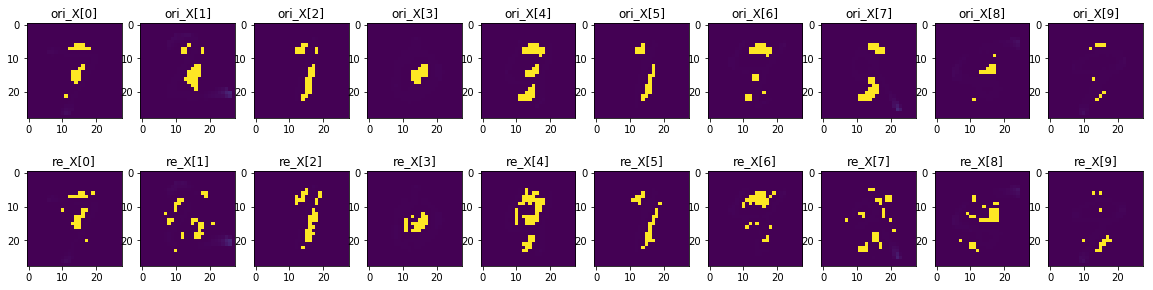

In [124]:
plt.figure(figsize=(20,5))
for i in range(10):
    ori_arr = X_test[i]
    re_arr = autoencoder.reconstruct(X_test)[i]
    ori_img = Image.fromarray(np.uint8(ori_arr.reshape(28,28)))
    re_img = Image.fromarray(np.uint8(re_arr.reshape(28,28)))
    
    plt.subplot(2, 10, i+1)
    plt.imshow(ori_img)
    plt.title('ori_X[%d]' % i) # 图像题目
    plt.subplot(2, 10, i+11)
    plt.title('re_X[%d]' % i) # 图像题目
    plt.imshow(re_img)
plt.legend()
plt.savefig('fig')
plt.show()
